# 이미지 분할 및 배경 흐리게 처리하기

In [1]:
# 라이브러리 로드
import cv2
import os
import urllib
import numpy as np
from matplotlib import pyplot as plt
from pixellib.semantic import semantic_segmentation

In [31]:
from PIL import Image

## 함수 정의

### 이미지 불러오기

In [2]:
def load_image(image_path):
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Loaded Image")
    plt.show()
    return img


### 모델 다운로드

In [3]:
def download_model(model_url, model_path):
    urllib.request.urlretrieve(model_url, model_path)

### 모델 로드

In [4]:
def load_model(model_path):
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_path)
    return model

### 이미지 분할

In [37]:
def get_label_names():
    return [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]

def print_class_labels_with_colormap(segvalues, colormap):
    LABEL_NAMES = get_label_names()
    for class_id in segvalues['class_ids']:
        print(f"Label: {LABEL_NAMES[class_id]}, ID: {class_id}, Color: {colormap[class_id]}")

def generate_colormap():
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    return colormap

def get_seg_color(colormap, label_index):
    return tuple(reversed(colormap[label_index]))


def get_image_rotation(image_path):
    try:
        image = Image.open(image_path)
        exif = image._getexif()
        orientation_key = 274  # Exif의 Orientation 태그
        if exif and orientation_key in exif:
            orientation = exif[orientation_key]
            return orientation
        else:
            return 1  # 기본값
    except Exception as e:
        print(f"Error in getting image rotation: {e}")
        return 1  # 기본값

def rotate_mask(mask, orientation):
    mask = mask.astype(np.uint8)  # 데이터 타입을 uint8로 변환
    if orientation == 3:
        mask = cv2.rotate(mask, cv2.ROTATE_180)
    elif orientation == 6:
        mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
    elif orientation == 8:
        mask = cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return mask



def create_seg_map(output, seg_color, img_path):
    orientation = get_image_rotation(img_path)
    seg_map = np.all(output == seg_color, axis=-1)
    seg_map = rotate_mask(seg_map, orientation)
    return seg_map

### 블러 처리

In [6]:
def blur_background(image, kernel_size):
    blurred = cv2.blur(image, kernel_size)
    plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
    plt.title("Blurred Background")
    plt.show()
    return blurred


### 이미지 합성

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def combine_images(original, mask, blurred, LABEL_NAMES):
    # 형상 일치를 위한 리사이징
    mask = (mask.astype(np.uint8)) * 255
    if original.shape[:2] != mask.shape:
        mask = cv2.resize(mask, (original.shape[1], original.shape[0]))

    mask_color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    bg_mask = cv2.bitwise_not(mask_color)

    # 마스킹된 이미지를 색상으로 변환
    color_mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)

    # 원본 이미지와 마스킹된 이미지를 합성
    img_show = cv2.addWeighted(original, 0.6, color_mask, 0.4, 0.0)

    # 형상 확인 및 리사이징
    print("Shape of original:", original.shape)
    print("Shape of mask_color:", mask_color.shape)
    print("Shape of blurred:", blurred.shape)

    if blurred.shape != bg_mask.shape:
        print("Resizing blurred image to match bg_mask.")
        blurred = cv2.resize(blurred, (bg_mask.shape[1], bg_mask.shape[0]))

    if blurred.shape == bg_mask.shape:
        bg_blur = cv2.bitwise_and(blurred, bg_mask)
    else:
        print("Error: The shapes of the blurred and background mask images do not match.")
        return None

    combined = np.where(mask_color == 255, original, bg_blur)

    # 원본 이미지와 처리된 이미지 함께 출력
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.title("Masked Image")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.title("Combined Image")

    plt.show()
    return combined


## 메인 코드

In [45]:
def main(img_path, model, filter_size=30):
    segvalues, output = model.segmentAsPascalvoc(img_path)
    print("Shape of segvalues['masks']:", np.shape(segvalues['masks']))
    print("Type of segvalues['masks']:", type(segvalues['masks']))
    print("Content of segvalues['masks']:", segvalues['masks'])

    colormap = generate_colormap()
    LABEL_NAMES = get_label_names()  # 라벨 이름을 가져오는 함수를 가정합니다.
    print_class_labels_with_colormap(segvalues, colormap)

    label_index = int(input("Enter the index of the object you want to segment: "))
    seg_color = get_seg_color(colormap, label_index)

    # img_path를 인자로 추가
    mask = create_seg_map(output, seg_color, img_path)
    print(mask.shape)

    plt.imshow(mask, cmap='gray')
    plt.show()

    # 원본 이미지 불러오기 (cv2를 사용하여 불러올 수 있습니다)
    original_image = cv2.imread(img_path)

    # 배경 흐리게 하기
    blurred = blur_background(original_image, (filter_size, filter_size))

    # 이미지 합성
    combined = combine_images(original_image, mask, blurred, LABEL_NAMES)

# 모델 경로 지정

In [41]:
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 모델 다운로드
download_model(model_url, model_file)
    
# 모델 불러오기
model = load_model(model_file)

## 사진1 고양이

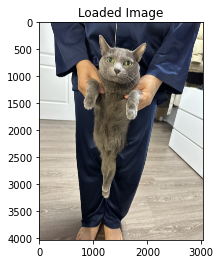

Shape of segvalues['masks']: (3024, 4032)
Type of segvalues['masks']: <class 'numpy.ndarray'>
Content of segvalues['masks']: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Label: background, ID: 0, Color: [0 0 0]
Label: cat, ID: 8, Color: [64  0  0]
Label: person, ID: 15, Color: [192 128 128]
Enter the index of the object you want to segment: 8
(4032, 3024)


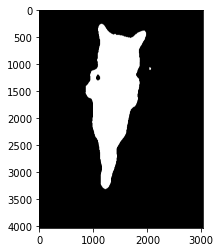

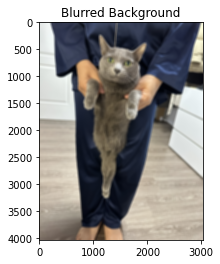

Shape of original: (4032, 3024, 3)
Shape of mask_color: (4032, 3024, 3)
Shape of blurred: (4032, 3024, 3)


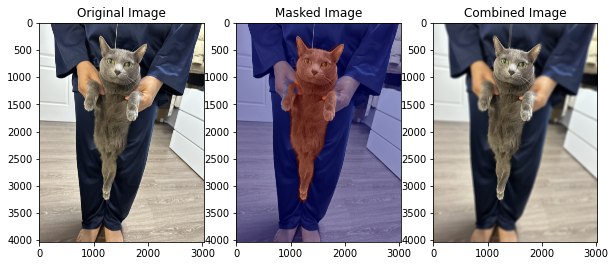

In [46]:
img_path = './catwithman.jpeg'
    
# 이미지 불러오기
original_image = load_image(img_path)
    
main(img_path, model, 50)

## 사진2 미인

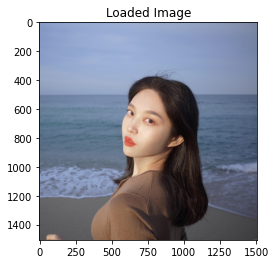

Shape of segvalues['masks']: (1506, 1507)
Type of segvalues['masks']: <class 'numpy.ndarray'>
Content of segvalues['masks']: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Label: background, ID: 0, Color: [0 0 0]
Label: boat, ID: 4, Color: [  0   0 128]
Label: person, ID: 15, Color: [192 128 128]
Enter the index of the object you want to segment: 15
(1506, 1507)


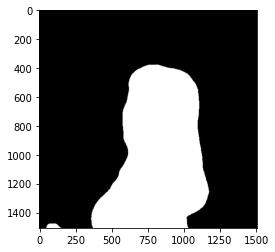

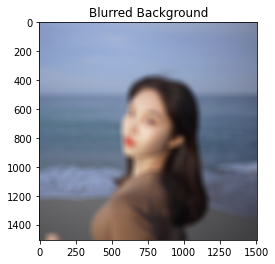

Shape of original: (1506, 1507, 3)
Shape of mask_color: (1506, 1507, 3)
Shape of blurred: (1506, 1507, 3)


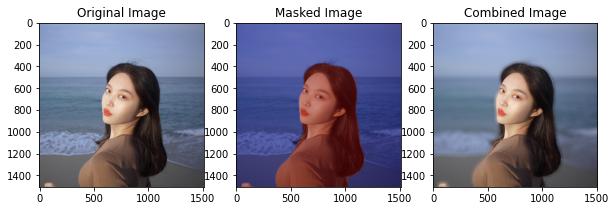

In [42]:
img_path = './oyknue.jpeg'
    
# 이미지 불러오기
original_image = load_image(img_path)
    
main(img_path, model, 50)

## 사진3 Korean Guy Over the Hannam-ru

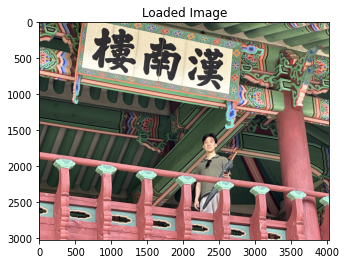

Shape of segvalues['masks']: (3024, 4032)
Type of segvalues['masks']: <class 'numpy.ndarray'>
Content of segvalues['masks']: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Label: background, ID: 0, Color: [0 0 0]
Label: bicycle, ID: 2, Color: [  0 128   0]
Label: person, ID: 15, Color: [192 128 128]
Enter the index of the object you want to segment: 15
(3024, 4032)


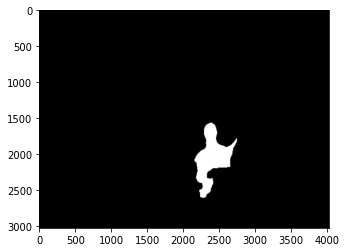

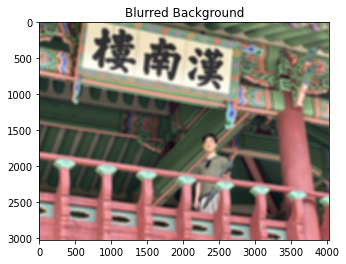

Shape of original: (3024, 4032, 3)
Shape of mask_color: (3024, 4032, 3)
Shape of blurred: (3024, 4032, 3)


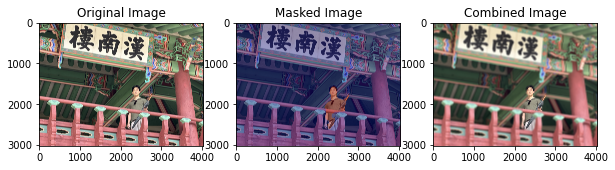

In [43]:
img_path = './guyoverhannam.jpeg'
    
# 이미지 불러오기
original_image = load_image(img_path)
    
main(img_path, model, 50)

## 사진4 심드렁한 닝겐

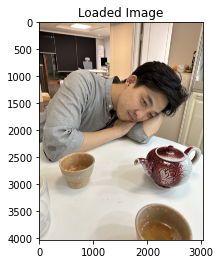

Shape of segvalues['masks']: (3024, 4032)
Type of segvalues['masks']: <class 'numpy.ndarray'>
Content of segvalues['masks']: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Label: background, ID: 0, Color: [0 0 0]
Label: person, ID: 15, Color: [192 128 128]
Label: tv, ID: 20, Color: [  0  64 128]
Enter the index of the object you want to segment: 15
(4032, 3024)


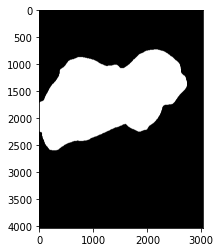

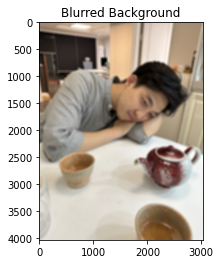

Shape of original: (4032, 3024, 3)
Shape of mask_color: (4032, 3024, 3)
Shape of blurred: (4032, 3024, 3)


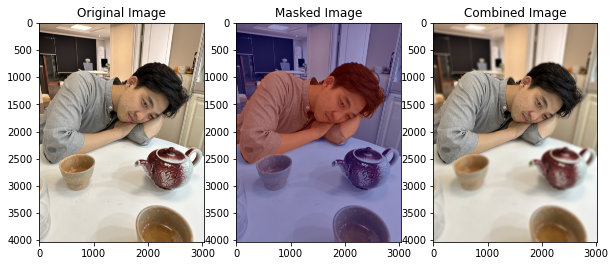

In [44]:
img_path = './symdrung.jpeg'
    
# 이미지 불러오기
original_image = load_image(img_path)
    
main(img_path, model, 50)

# 회고

이번 프로젝트에서 가장 많은 시간을 들인 것은 코드를 모듈화하는 것이었다.
거의 3-4시간을 들였는데, 모듈화 이후 메인함수 형태로 기능을 사용하니 *정말 말도 안되게 편하다.*

하지만 예상했던 것보다 훨씬 많은 시간이 걸렸는데, 이유는 두가지다.

1. 실제 모듈화가 필요한 과정이 체감한 것보다 훨씬 많았다.
이미지를 마스킹해서 뒷부분을 필터처리한다는 것이, 사진만 놓고 보면 3단계처럼 보이지만 실제로는 15-20단계 정도가 걸린다.
그 과정에서 예기치 못한 엣지 케이스나 상황을 해결하는 것에 상당한 시간이 들었다.

2. 예기치 못한 상황 처리
제일 난감했던 것은 사진의 메타데이터가 갖고 있는 로테이션 값 때문에, 마스킹 과정에서 이미지가 저절로 누워버리는 것이었다. 이걸 모른채로 합성을 계속 시도해서 에러가 발생했는데, 이 문제를 나중에 알고 처리하는 과정에서 시간이 많이 걸렸다.


만약 유사한 프로젝트를 다시 수행한다면... 엣지 케이스를 미리 기록해두고, 각 단계별로 그것들을 처리하면서 다음 작업으로 넘어갔을 것 같다. 물론 엣지 케이스가 무엇이 발생할지 모두 예측하는 것은 불가능하다. 그렇지만 전체 프로세스가 긴밀하게 완료된 상태에서 중간 과정에서 발생한 문제를 처리하는 것은 더 복잡한 것 같다.

가장 좋은 것은 역시 사람들이 역할을 나누어서 수행하는 것일 듯하다. 전체 과정을 설계하고, 큰 덩어리 단위를 짧게 만든 다음, 그 파이프라인에서 넘겨받은 결과를 처리하는 부분을 나누어서 수행하고, 각 단계의 심도를 높이는 것은 개인이 처리하는 것.

결국 하나의 작업을 수행하기 전에 기획하고, 파악하고, 논의하는 충분한 시간을 갖는 것이 중요하다는 인사이트를 다시 확인한다.

물론 현재 개인이 작은 프로젝트를 모두 수행하는 노드의 방식과는 조금 한계가 있겠지만, 일을 할 때에는 요렇게!